In [2]:
%cd ~/projects/genre-classification

/home/denhart.c/projects/genre-classification


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
import os
import librosa
import matplotlib.pyplot as plt
from librosa import display
import numpy as np
import torch
from typing import Tuple
from IPython.display import Audio
import keras
from torch.nn.utils.rnn import pad_sequence
import itertools as it
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import random
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import sys
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from typing import List, Callable, Tuple, Dict
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm
from torch.utils.data import DataLoader, Dataset
from collections import Counter
import seaborn as sns
import pytorch_lightning as pl

In [4]:
DATA_DIR = '/home/denhart.c/data'

## Explore

In [283]:
wav_fp = "genres/blues/blues.00000.wav"
wav_fp2 = "genres/classical/classical.00000.wav"
data, sr = librosa.load(os.path.join(DATA_DIR, wav_fp))
data2, sr2 = librosa.load(os.path.join(DATA_DIR, wav_fp2))

/home/denhart.c/projects/genre-classification/.venv/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/denhart.c/projects/genre-classification/.venv/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/denhart.c/projects/genre-classification/.venv/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


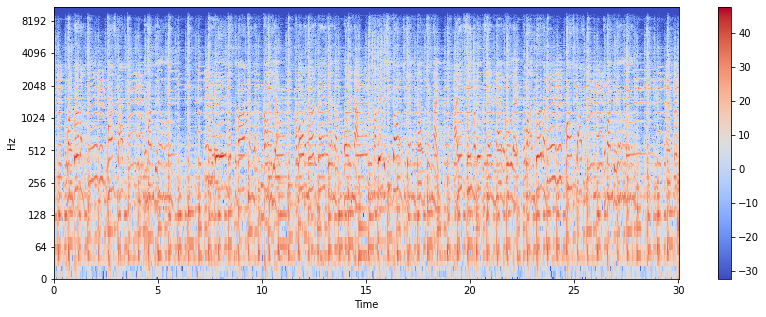

In [284]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

In [17]:
X = librosa.stft(data2)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

In [18]:
chroma = librosa.feature.chroma_cqt(y=data, sr=sr)

In [19]:
chroma.shape

(12, 1293)

In [20]:
plt.figure(figsize=(14, 5))
display.specshow(chroma, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.show()

In [21]:
plt.hist(Xdb[0])

(array([ 23.,  19.,  27.,  81., 148., 256., 347., 274.,  94.,  24.]),
 array([-43.539154  , -38.051712  , -32.564274  , -27.076832  ,
        -21.589392  , -16.10195   , -10.61451   ,  -5.1270685 ,
          0.36037216,   5.847813  ,  11.335254  ], dtype=float32),
 <BarContainer object of 10 artists>)

In [26]:
Audio(data, rate=sr)

## Initialize

### Collect Data

In [18]:
derived_feature_names = [
    'chroma_mean',
    'chroma_var',
    'spec_cent_mean',
    'spec_cent_var',
    'spec_band_mean',
    'spec_band_var',
    'spec_roll_mean',
    'spec_roll_var',
    'zcr_mean',
    'zcr_var',
    'tempogram_mean',
    'tempogram_var',
]
derived_feature_names += ['mfcc_mean_' + str(i) for i in range(20)] \
                      + ['mfcc_var_' + str(i) for i in range(20)]

In [48]:
def derived_features(x: np.ndarray, sr: int) -> np.ndarray:
    chroma_stft = librosa.feature.chroma_stft(x, sr)
    spec_cent = librosa.feature.spectral_centroid(x, sr)
    spec_bw = librosa.feature.spectral_bandwidth(x, sr)
    rolloff = librosa.feature.spectral_rolloff(x, sr)
    zcr = librosa.feature.zero_crossing_rate(x)
    tempogram = librosa.feature.tempogram(x, sr)
    mfcc = librosa.feature.mfcc(x, sr)
    mfcc_means = np.stack([np.mean(e) for e in mfcc])
    mfcc_vars = np.stack([np.std(e) for e in mfcc])
    feature_stack = np.stack([
        np.mean(chroma_stft), 
        np.std(chroma_stft),
        np.mean(spec_cent), 
        np.std(spec_cent),
        np.mean(spec_bw), 
        np.std(spec_bw),
        np.mean(rolloff), 
        np.std(rolloff),
        np.mean(zcr),
        np.std(zcr),
        np.mean(tempogram),
        np.std(tempogram)
    ])
    full_stack = np.concatenate([feature_stack, mfcc_means, mfcc_vars])
    return full_stack

In [20]:
def audio_to_sequence(x: np.ndarray, to_db: bool = False) -> np.ndarray:
    amplitudes = abs(librosa.stft(x))
    time_amplitudes = amplitudes.reshape(amplitudes.shape[1], amplitudes.shape[0])
    if to_db:
        return librosa.amplitude_to_db(time_amplitudes)
    return time_amplitudes

In [21]:
def sequence_to_audio(X: np.ndarray, from_db: bool = False) -> np.ndarray:
    # todo: reshape?
    values = librosa.db_to_amplitude(X) if from_db else X
    return librosa.istft(values)

In [22]:
def embed_X(X: List[np.ndarray], embed_fn: Callable[[np.ndarray], np.ndarray]) -> List[np.ndarray]:
    embeddings = [embed_fn(x) for x in X]
    return embeddings

In [31]:
def read_data(subset_pct: float = 1.0) -> Tuple[List[str], List[str]]:
    '''Return audio filepaths and associated genre labels'''
    # extract all genre names
    genre_dir = os.path.join(DATA_DIR, 'genres')
    genre_names = [fname for fname in os.listdir(genre_dir) 
                   if os.path.isdir(os.path.join(genre_dir, fname))]
    
    # collect filepaths along with their associated genres
    filepaths = []
    labels = []
    for genre in genre_names:
        genre_files = os.listdir(os.path.join(DATA_DIR, 'genres', genre))
        genre_paths = [os.path.join(DATA_DIR, 'genres', genre, fname) for fname in genre_files]
        filepaths += genre_paths
        labels += ([genre] * len(genre_files))
        
    # select random subset of files
    n_total_files = len(filepaths)
    n_subset_files = int(subset_pct * n_total_files)
    random_rows = np.random.choice(range(n_total_files), n_subset_files)
    filepaths_subset = [filepaths[i] for i in random_rows]
    labels_subset = [labels[i] for i in random_rows]
    
    return filepaths_subset, labels_subset

In [32]:
def split_data(X: np.ndarray, y: np.ndarray, use_val: bool = False) -> List[np.ndarray]:
    n_total_rows = X.shape[0]
    train_split, val_split, test_split = 0.6, 0.1, 0.3
    train_rows = np.random.choice(n_total_rows, int(train_split * n_total_rows), replace=False)
    
    if use_val:
        avail_rows = [i for i in range(n_total_rows) if i not in train_rows]
        val_rows = np.random.choice(avail_rows, int(val_split * n_total_rows), replace=False)
        test_rows = [i for i in range(n_total_rows) 
                     if i not in train_rows and i not in val_rows]
    else:
        test_rows = [i for i in range(n_total_rows) if i not in train_rows]
        
    out_data = [
        X[train_rows],
        y[train_rows],
        X[test_rows],
        y[test_rows]
    ]
    
    if use_val:
        out_data += [X[val_rows], y[val_rows]]
        
    return out_data

In [33]:
class MultiClassDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

class QueryDataset(Dataset):
    def __init__(self, X, genre_labels):
        unique_genres = set(genre_labels)
        new_X = []
        genres = []
        y = []
        for x, genre_label in zip(X, genre_labels):
            neg_options = [g for g in unique_genres if g != genre_label]
            neg_genre = np.random.choice(neg_options)
            new_X += [x, x]
            genres += [genre_label, neg_genre]
            y += [1, 0]
            
        self.X = torch.stack(new_X)
        self.genres = torch.tensor(genres)
        self.y = torch.tensor(y)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.genres[idx], self.y[idx]

In [36]:
filepaths, labels = read_data()

In [37]:
y_encoder = LabelEncoder()
y = torch.tensor(y_encoder.fit_transform(labels))
y_classes = y_encoder.classes_
# y = torch.tensor(np_utils.to_categorical(y_cat))

In [38]:
y_genres = [y_classes[idx] for idx in y]
Counter(y_genres)

Counter({'blues': 106,
         'pop': 96,
         'disco': 96,
         'classical': 115,
         'jazz': 109,
         'rock': 82,
         'metal': 101,
         'country': 103,
         'hiphop': 91,
         'reggae': 101})

In [39]:
X = [librosa.load(fpath)[0] for fpath in filepaths]

In [49]:
# feature data
emb_X = embed_X(X, lambda x: derived_features(x, sr))
derived_X = torch.tensor(np.stack([x for x in emb_X])).float()

In [50]:
derived_df = pd.DataFrame(derived_X.numpy())
derived_df.columns = derived_feature_names

In [52]:
derived_df.to_csv('cache/derived_df.csv', index=False)

In [41]:
# sequence data
emb_X = embed_X(X, audio_to_sequence)
min_len = min([x.shape[0] for x in emb_X])
seq_X = torch.tensor(np.stack([x[:min_len, :] for x in emb_X])).float()

## Modeling

### Step 1: Baseline Modeling

In [57]:
X_train, y_train, X_test, y_test = split_data(derived_X, y)

In [58]:
clf = RandomForestClassifier().fit(X_train, y_train)

In [59]:
y_pred = clf.predict(X_test)

In [60]:
accuracy_score(y_test, y_pred)

0.8

In [61]:
class_report = classification_report(y_test, y_pred, labels=list(set(y.tolist())), target_names=y_classes, zero_division=0)

In [62]:
print(class_report)

              precision    recall  f1-score   support

       blues       0.83      0.87      0.85        45
   classical       0.95      1.00      0.97        37
     country       0.78      0.85      0.81        46
       disco       0.73      0.80      0.77        41
      hiphop       0.85      0.85      0.85        33
        jazz       0.74      0.84      0.78        37
       metal       0.93      0.93      0.93        45
         pop       0.83      0.78      0.81        37
      reggae       0.70      0.70      0.70        44
        rock       0.55      0.31      0.40        35

    accuracy                           0.80       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.79      0.80      0.79       400



In [63]:
feature_importances = dict(zip(derived_feature_names, clf.feature_importances_))

In [67]:
sorted_fis = sorted_keys = sorted(feature_importances, key=feature_importances.get)

In [72]:
sorted_fis[:5]

['mfcc_var_14', 'mfcc_var_13', 'mfcc_var_15', 'mfcc_var_17', 'spec_band_var']

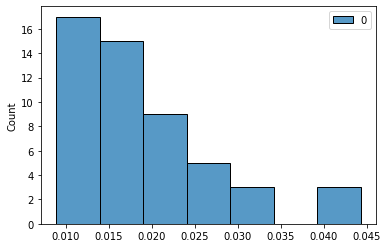

In [65]:
sns.histplot(feature_importances.values())
plt.show()

In [76]:
clf = svm.SVC(decision_function_shape='ovo', kernel='linear').fit(X_train, y_train)

In [77]:
y_pred = clf.predict(X_test)

In [78]:
accuracy_score(y_test, y_pred)

0.7625

### Step 2: Derive Genre Embedding

Train an MLP to classify genre using derived audio features.  Then average hidden layers per genre to obtain genre embedding.

In [143]:
X_train, y_train, X_test, y_test, X_val, y_val = split_data(derived_X, y, use_val=True)

In [250]:
class GenreEmbedder(pl.LightningModule):
    
    def __init__(self, input_dim, n_class, embedding_size=32):
        super(GenreEmbedder, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=2, stride=1, padding=1),
            # nn.BatchNorm2d(1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=1),
        )
        self.in_layer = nn.Linear(52, 48)
        self.embedding = nn.Linear(48, embedding_size)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(embedding_size, n_class)
        
        self.loss = nn.CrossEntropyLoss()
        
        self.train_acc = pl.metrics.Accuracy()
        self.val_acc = pl.metrics.Accuracy()
        self.test_acc = pl.metrics.Accuracy()
    
    def forward(self, x):
        b, f = x.shape
        x_reshape = x.reshape(b, 1, 4, 13)
        conv_layer = self.activation(self.cnn(x_reshape)).reshape(b, 70)
        embedding = self.activation(self.embedding(self.activation(self.in_layer(x))))
        out = self.out(embedding)
        return out, embedding

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self(x)
        loss = self.loss(y_hat, y)
        self.log('train_loss', loss)
        # self.log('train_acc', self.train_acc, on_step=True, on_epoch=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self(x)
        loss = self.loss(y_hat, y)
        self.log('validation_loss', loss)
        # self.log('val_acc', self.val_acc, on_step=True, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self(x)
        loss = self.loss(y_hat, y)
        self.log('test_loss', loss)
        # self.log('test_acc', self.test_acc, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [251]:
trainset = MultiClassDataset(X_train, y_train)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)
valset = MultiClassDataset(X_val, y_val)
valloader = DataLoader(valset, num_workers=2)
testset = MultiClassDataset(X_test, y_test)
testloader = DataLoader(testset, batch_size=8, num_workers=2)
ge = GenreEmbedder(X_train.shape[-1], len(y_classes))
trainer = pl.Trainer(gpus=0, min_epochs=5, max_epochs=200)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [252]:
trainer.fit(ge, trainloader, valloader)

Set SLURM handle signals.

  | Name       | Type             | Params
------------------------------------------------
0 | cnn        | Sequential       | 5     
1 | in_layer   | Linear           | 2.5 K 
2 | embedding  | Linear           | 1.6 K 
3 | activation | ReLU             | 0     
4 | dropout    | Dropout          | 0     
5 | out        | Linear           | 330   
6 | loss       | CrossEntropyLoss | 0     
7 | train_acc  | Accuracy         | 0     
8 | val_acc    | Accuracy         | 0     
9 | test_acc   | Accuracy         | 0     
------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/home/denhart.c/projects/genre-classification/.venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:   0%|          | 0/175 [00:00<?, ?it/s]                      

/home/denhart.c/projects/genre-classification/.venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  43%|████▎     | 75/175 [00:00<00:01, 76.52it/s, loss=10.7, v_num=1.84e+7]
Validating: 0it [00:00, ?it/s]
Epoch 1:  43%|████▎     | 75/175 [00:00<00:01, 87.69it/s, loss=5.41, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  43%|████▎     | 75/175 [00:00<00:01, 81.03it/s, loss=4.71, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 3:  43%|████▎     | 75/175 [00:00<00:01, 89.72it/s, loss=3.94, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 4:  43%|████▎     | 75/175 [00:01<00:01, 74.06it/s, loss=3.81, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 5:  43%|████▎     | 75/175 [00:00<00:01, 80.09it/s, loss=3.42, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  43%|████▎     | 75/175 [00:01<00:01, 74.14it/s, loss=2.68, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 7:  43%|████▎     | 75/175 [00:00<00:01, 93.52it/s, loss=3.31, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 8:  43%|████▎     | 75/175 [00:00<00:01, 87.61it/s, loss=3.23, 

Epoch 18:  43%|████▎     | 75/175 [00:00<00:01, 77.81it/s, loss=2.32, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 19:  43%|████▎     | 75/175 [00:00<00:01, 83.93it/s, loss=2.32, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 20:  43%|████▎     | 75/175 [00:00<00:01, 82.21it/s, loss=2.25, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 21:  43%|████▎     | 75/175 [00:00<00:01, 83.71it/s, loss=2.06, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 22:  43%|████▎     | 75/175 [00:00<00:01, 88.67it/s, loss=2.09, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 23:  43%|████▎     | 75/175 [00:00<00:01, 80.80it/s, loss=1.87, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 24:  43%|████▎     | 75/175 [00:00<00:01, 81.14it/s, loss=1.8, v_num=1.84e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 25:  43%|████▎     | 75/175 [00:00<00:01, 96.57it/s, loss=2.03, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 26:  43%|████▎     | 75/175 [00:00<00:01, 92.75it/s,

Epoch 36:  43%|████▎     | 75/175 [00:00<00:01, 80.27it/s, loss=1.77, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 37:  43%|████▎     | 75/175 [00:00<00:01, 79.24it/s, loss=1.72, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 38:  43%|████▎     | 75/175 [00:00<00:01, 80.60it/s, loss=1.67, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 39:  43%|████▎     | 75/175 [00:00<00:01, 87.14it/s, loss=1.77, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 40:  43%|████▎     | 75/175 [00:00<00:01, 89.80it/s, loss=1.78, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 41:  43%|████▎     | 75/175 [00:00<00:01, 77.37it/s, loss=1.71, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 42:  43%|████▎     | 75/175 [00:00<00:01, 94.72it/s, loss=1.44, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 43:  43%|████▎     | 75/175 [00:00<00:01, 82.07it/s, loss=1.74, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 44:  43%|████▎     | 75/175 [00:00<00:01, 90.48it/

Epoch 54:  43%|████▎     | 75/175 [00:01<00:01, 65.87it/s, loss=1.42, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 55:  43%|████▎     | 75/175 [00:00<00:01, 87.85it/s, loss=1.52, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 56:  43%|████▎     | 75/175 [00:00<00:01, 80.96it/s, loss=1.33, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 57:  43%|████▎     | 75/175 [00:00<00:01, 85.08it/s, loss=1.36, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 58:  43%|████▎     | 75/175 [00:00<00:01, 86.80it/s, loss=1.36, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 59:  43%|████▎     | 75/175 [00:00<00:01, 82.02it/s, loss=1.38, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 60:  43%|████▎     | 75/175 [00:01<00:01, 62.81it/s, loss=1.38, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 61:  43%|████▎     | 75/175 [00:00<00:01, 97.89it/s, loss=1.34, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 62:  43%|████▎     | 75/175 [00:00<00:01, 78.86it/s, 

Epoch 72:  43%|████▎     | 75/175 [00:00<00:01, 94.82it/s, loss=1.42, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 73:  43%|████▎     | 75/175 [00:00<00:01, 77.81it/s, loss=1.35, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 74:  43%|████▎     | 75/175 [00:00<00:00, 100.73it/s, loss=1.23, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 75:  43%|████▎     | 75/175 [00:00<00:01, 92.80it/s, loss=1.51, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 76:  43%|████▎     | 75/175 [00:00<00:01, 89.67it/s, loss=1.33, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 77:  43%|████▎     | 75/175 [00:00<00:01, 77.49it/s, loss=1.37, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 78:  43%|████▎     | 75/175 [00:00<00:01, 89.39it/s, loss=1.34, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 79:  43%|████▎     | 75/175 [00:00<00:01, 82.53it/s, loss=1.4, v_num=1.84e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 80:  43%|████▎     | 75/175 [00:00<00:01, 94.54it/

Validating: 0it [00:00, ?it/s]
Epoch 91:  43%|████▎     | 75/175 [00:00<00:01, 84.09it/s, loss=1.4, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 92:  43%|████▎     | 75/175 [00:00<00:01, 90.38it/s, loss=1.34, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 93:  43%|████▎     | 75/175 [00:00<00:01, 81.53it/s, loss=1.53, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 94:  43%|████▎     | 75/175 [00:00<00:01, 87.83it/s, loss=1.36, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 95:  43%|████▎     | 75/175 [00:00<00:01, 91.66it/s, loss=1.31, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 96:  43%|████▎     | 75/175 [00:00<00:01, 97.58it/s, loss=1.27, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 97:  43%|████▎     | 75/175 [00:00<00:01, 88.15it/s, loss=1.18, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 98:  43%|████▎     | 75/175 [00:01<00:01, 73.20it/s, loss=1.03, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 99:  43%|████▎     | 

Epoch 108:  43%|████▎     | 75/175 [00:00<00:01, 91.33it/s, loss=1.25, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 109:  43%|████▎     | 75/175 [00:00<00:01, 81.50it/s, loss=1.36, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 110:  43%|████▎     | 75/175 [00:00<00:01, 90.54it/s, loss=1.26, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 111:  43%|████▎     | 75/175 [00:00<00:01, 85.51it/s, loss=1.34, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 112:  43%|████▎     | 75/175 [00:01<00:01, 65.73it/s, loss=1.2, v_num=1.84e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 113:  43%|████▎     | 75/175 [00:00<00:01, 84.18it/s, loss=1.09, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 114:  43%|████▎     | 75/175 [00:00<00:01, 99.90it/s, loss=1.13, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 115:  43%|████▎     | 75/175 [00:00<00:01, 89.51it/s, loss=1.55, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 116:  43%|████▎     | 75/175 [00:01<00:01, 66

Epoch 127:  43%|████▎     | 75/175 [00:01<00:01, 61.44it/s, loss=1.18, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 128:  43%|████▎     | 75/175 [00:00<00:01, 88.18it/s, loss=1.07, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 129:  43%|████▎     | 75/175 [00:00<00:01, 81.75it/s, loss=1.07, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 130:  43%|████▎     | 75/175 [00:00<00:01, 88.48it/s, loss=1.09, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 131:  43%|████▎     | 75/175 [00:00<00:01, 83.22it/s, loss=1.01, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 132:  43%|████▎     | 75/175 [00:00<00:01, 89.68it/s, loss=1.27, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 133:  43%|████▎     | 75/175 [00:00<00:01, 81.55it/s, loss=1.16, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 134:  43%|████▎     | 75/175 [00:00<00:01, 97.59it/s, loss=1.21, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 135:  43%|████▎     | 75/175 [00:00<00:01, 8

Epoch 144:  43%|████▎     | 75/175 [00:00<00:01, 94.26it/s, loss=1.31, v_num=1.84e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 145:  43%|████▎     | 75/175 [00:00<00:01, 94.21it/s, loss=0.971, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 146:  43%|████▎     | 75/175 [00:00<00:01, 82.41it/s, loss=1, v_num=1.84e+7]      
Validating: 0it [00:00, ?it/s]
Epoch 147:  43%|████▎     | 75/175 [00:00<00:01, 80.49it/s, loss=1.12, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 148:  43%|████▎     | 75/175 [00:00<00:01, 91.06it/s, loss=1.06, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 149:  43%|████▎     | 75/175 [00:00<00:01, 79.52it/s, loss=1.2, v_num=1.84e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 150:  43%|████▎     | 75/175 [00:00<00:01, 76.28it/s, loss=0.936, v_num=1.84e+7]
Validating: 0it [00:00, ?it/s]
Epoch 151:  43%|████▎     | 75/175 [00:01<00:01, 72.55it/s, loss=1.05, v_num=1.84e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 152:  43%|████▎     | 75/175 [00:00<00:01

Epoch 163:  43%|████▎     | 75/175 [00:00<00:01, 82.17it/s, loss=1.08, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 164:  43%|████▎     | 75/175 [00:01<00:01, 71.44it/s, loss=1.03, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 165:  43%|████▎     | 75/175 [00:00<00:01, 80.44it/s, loss=1.09, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 166:  43%|████▎     | 75/175 [00:00<00:01, 82.35it/s, loss=1.05, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 167:  43%|████▎     | 75/175 [00:00<00:01, 91.18it/s, loss=0.909, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 168:  43%|████▎     | 75/175 [00:00<00:01, 80.71it/s, loss=1.24, v_num=1.84e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 169:  43%|████▎     | 75/175 [00:00<00:01, 86.65it/s, loss=1.15, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 170:  43%|████▎     | 75/175 [00:00<00:01, 86.82it/s, loss=0.998, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 171:  43%|████▎     | 75/175 [00:00<00:01, 

Epoch 180:  43%|████▎     | 75/175 [00:00<00:01, 80.53it/s, loss=0.971, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 181:  43%|████▎     | 75/175 [00:00<00:01, 89.21it/s, loss=1.2, v_num=1.84e+7]    
Validating: 0it [00:00, ?it/s]
Epoch 182:  43%|████▎     | 75/175 [00:00<00:01, 85.19it/s, loss=1.04, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 183:  43%|████▎     | 75/175 [00:00<00:01, 83.95it/s, loss=0.927, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 184:  43%|████▎     | 75/175 [00:01<00:01, 68.47it/s, loss=0.959, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 185:  43%|████▎     | 75/175 [00:01<00:01, 68.90it/s, loss=0.879, v_num=1.84e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 186:  43%|████▎     | 75/175 [00:00<00:01, 93.94it/s, loss=0.955, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 187:  43%|████▎     | 75/175 [00:00<00:01, 81.05it/s, loss=0.932, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 188:  43%|████▎     | 75/175 [00:00<00:

Epoch 198:  43%|████▎     | 75/175 [00:00<00:01, 84.44it/s, loss=0.932, v_num=1.84e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 199:  43%|████▎     | 75/175 [00:00<00:01, 97.55it/s, loss=1.01, v_num=1.84e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 199: 100%|██████████| 175/175 [00:01<00:00, 115.38it/s, loss=1.01, v_num=1.84e+7]


1

In [101]:
trainer.test(test_dataloaders=testloader)

Testing: 0it [00:00, ?it/s]

/home/denhart.c/projects/genre-classification/.venv/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing: 100%|██████████| 38/38 [00:01<00:00, 37.75it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.0081522464752197}
--------------------------------------------------------------------------------


[{'test_loss': 2.0081522464752197}]

In [253]:
ge.eval()

GenreEmbedder(
  (cnn): Sequential(
    (0): Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  )
  (in_layer): Linear(in_features=52, out_features=48, bias=True)
  (embedding): Linear(in_features=48, out_features=32, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=32, out_features=10, bias=True)
  (loss): CrossEntropyLoss()
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
)

In [260]:
test_X, test_y = testset[:]

In [261]:
y_pred = torch.argmax(ge(test_X)[0], dim=-1)

In [264]:
accuracy_score(test_y, y_pred)

0.6266666666666667

In [262]:
class_report = classification_report(test_y, y_pred)

In [263]:
print(class_report)

              precision    recall  f1-score   support

           0       0.79      0.66      0.72        35
           1       0.89      0.89      0.89        37
           2       0.73      0.34      0.47        32
           3       0.50      0.04      0.07        26
           4       0.71      0.69      0.70        32
           5       0.40      0.90      0.56        30
           6       0.75      0.86      0.80        28
           7       0.79      0.68      0.73        28
           8       0.52      0.67      0.59        33
           9       0.29      0.32      0.30        19

    accuracy                           0.63       300
   macro avg       0.64      0.60      0.58       300
weighted avg       0.66      0.63      0.61       300



In [265]:
def assign_embeddings(X: torch.tensor, y: torch.tensor, embedder: GenreEmbedder) -> Dict[int, torch.tensor]:
    genre_embeddings = {}
    for genre in set(y.tolist()):
        y_idx = torch.where(y == genre)[0]
        X_y = X[y_idx]
        _, embs = embedder(X_y)
        mean_embs = torch.mean(embs, dim=0)
        genre_embeddings[genre] = mean_embs
    return genre_embeddings

In [267]:
genre_embeddings = assign_embeddings(X_train, y_train, ge)

### Step 3: Binary Classification with Attention
Query an audio sequence with a genre embedding and classify whether or not that audio sequence belongs to the given genre

In [268]:
X_train, y_train, X_test, y_test, X_val, y_val = split_data(seq_X, y, use_val=True)

In [273]:
class QueryClassifier(pl.LightningModule):
    
    def __init__(self, input_shape, genre_embeddings, embedding_size=32, n_heads=4):
        super(QueryClassifier, self).__init__()
        self.genre_embeddings = genre_embeddings
        self.lstm = nn.LSTM(input_shape, embedding_size, 1, batch_first=True)
        # self.lstm2 = nn.LSTM(128, embedding_size, 1, batch_first=True)
        self.attention = torch.nn.MultiheadAttention(embedding_size, n_heads)
        self.out = nn.Linear(embedding_size, 1)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.loss = nn.BCELoss()
        
    def forward(self, x, genres):
        lstm_out, _ = self.lstm(x)
        # lstm2_out, _ = self.lstm2(lstm1_out)
        b, l, e = lstm_out.shape
        genre_emb = torch.stack([self.genre_embeddings[int(g)] for g in genres])
        query = genre_emb.unsqueeze(0)
        key = lstm_out.reshape(l, b, e)
        attn_out, attn_weights = self.attention(query, key, key)
        out = self.sigmoid(self.activation(self.out(attn_out)))
        return out.squeeze(), attn_weights.detach()

    def training_step(self, batch, batch_idx):
        x, genre, y = batch
        y_hat, _ = self(x, genre)
        loss = self.loss(y_hat, y.float())
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, genre, y = batch
        y_hat, _ = self(x, genre)
        loss = self.loss(y_hat, y.float())
        self.log('validation_loss', loss)
        return loss
    
    def testing_step(self, batch, batch_idx):
        x, genre, y = batch
        y_hat, _ = self(x, genre)
        loss = self.loss(y_hat, y.float())
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer
    
    def backward(self, loss, optimizer, optimizer_idx):
        loss.backward(retain_graph=True)

In [274]:
trainset = QueryDataset(X_train, y_train)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True)
valset = QueryDataset(X_val, y_val)
valloader = DataLoader(valset, batch_size=8)
testset = QueryDataset(X_test, y_test)
testloader = DataLoader(testset, batch_size=8)
qc = QueryClassifier(X_train.shape[-1], genre_embeddings)
trainer = pl.Trainer(gpus=0, max_epochs=5)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [275]:
trainer.fit(qc, trainloader, valloader)

Set SLURM handle signals.

  | Name       | Type               | Params
--------------------------------------------------
0 | lstm       | LSTM               | 135 K 
1 | attention  | MultiheadAttention | 4.2 K 
2 | out        | Linear             | 33    
3 | activation | ReLU               | 0     
4 | sigmoid    | Sigmoid            | 0     
5 | loss       | BCELoss            | 0     
--------------------------------------------------
139 K     Trainable params
0         Non-trainable params
139 K     Total params
0.559     Total estimated model params size (MB)


Epoch 0:  86%|████████▌ | 150/175 [01:08<00:11,  2.18it/s, loss=0.694, v_num=1.84e+7]
Validating: 0it [00:00, ?it/s]
Epoch 1:  86%|████████▌ | 150/175 [01:07<00:11,  2.22it/s, loss=0.694, v_num=1.84e+7]
Validating: 0it [00:00, ?it/s]
Epoch 2:  86%|████████▌ | 150/175 [01:06<00:11,  2.25it/s, loss=0.693, v_num=1.84e+7]
Validating: 0it [00:00, ?it/s]
Epoch 3:  86%|████████▌ | 150/175 [01:05<00:10,  2.29it/s, loss=0.693, v_num=1.84e+7]
Validating: 0it [00:00, ?it/s]
Epoch 4:  86%|████████▌ | 150/175 [01:04<00:10,  2.31it/s, loss=0.694, v_num=1.84e+7]
Validating: 0it [00:00, ?it/s]
Validating:  16%|█▌        | 4/25 [00:00<00:02,  9.39it/s]


Epoch 4: 100%|██████████| 175/175 [01:08<00:00,  2.57it/s, loss=0.694, v_num=1.84e+7]


1

In [276]:
test_dataset = QueryDataset(X_test, y_test)

In [277]:
test_X, test_genres, test_labels = test_dataset[:]

In [278]:
y_pred, weights = qc(test_X, test_genres)

In [279]:
thresholds = [t / 100 for t in range(40, 60, 1)]

In [280]:
best_acc = 0
best_t = thresholds[0]
best_pred = None
for t in thresholds:
    y_pred_rd = [1 if p > t else 0 for p in y_pred]
    new_acc = accuracy_score(test_labels, y_pred_rd)
    if new_acc > best_acc:
        best_acc = new_acc
        best_t = t
        best_pred = y_pred_rd

In [281]:
best_acc

0.5016666666666667

## Analysis

In [286]:
def apply_attn_to_sequences(seqs: torch.Tensor, attn: torch.Tensor) -> torch.Tensor:
    '''Apply the attention layer (attended over a sentence + image) to the original image.'''
    # normalize the attention layer
    norm_attn = attn / (1 / (attn.size()[0] * attn.size()[1]))

    # expand the attention layer to match the size of the image
    expanded_attn = torch.nn.functional.interpolate(norm_attn.unsqueeze(0).unsqueeze(0),
                                                    size=(seqs.shape[0], seqs.shape[1]),
                                                    mode='bicubic',
                                                    align_corners=False)\
                                       .squeeze()

    # element-wise multiply the normalized attention weights by image pixels
    transformed_seqs = seqs * expanded_attn

    return transformed_seqs

In [27]:
emb_data = preprocess(data)

NameError: name 'preprocess' is not defined

In [28]:
emb_data.shape

NameError: name 'emb_data' is not defined

In [25]:
attn = build_rand_attn(0, 64, 64, 0.1)

In [26]:
emb_attn = apply_attn_to_img(torch.tensor(emb_data), attn)

In [27]:
rev_attn = reverse_preprocess(emb_attn.detach().numpy())

In [28]:
Audio(rev_attn, rate=sr)

In [29]:
Audio(data, rate=sr)

In [57]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/